# Inspect U-Net
Using U-Net on real AFM data

-- Chang (Chris) Qian

## Load packages

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import h5py


from tensorflow import keras
from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger
from keras.initializers import *


os.listdir('.')

['.ipynb_checkpoints',
 '20230923_002_good.hdf5',
 'AFM_20230924_002.ipynb',
 'AFM_20240311_001.ipynb',
 'Inspection_20240312.ipynb',
 'log.csv',
 'Model']

In [4]:
def addDimension(m):
    temp = np.zeros([m.shape[0],m.shape[1],1])
    temp = np.concatenate((m,temp), axis=2)
    return temp


## Load data and run U-Net prediction
Need AFM dataset in the shape of (n,128,128), with n as the number of images

Network Loaded
Predicting AFM data
(198, 128, 128)
10/10 [==============================] - 10s 154ms/step


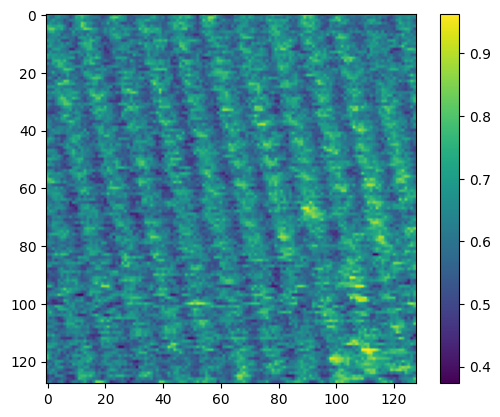

In [2]:
model_path = 'U-Net model_20230923_002.hdf5'
model = load_model(model_path)
print("Network Loaded")

print('Predicting AFM data')
rawdata_path = 'AFM data 1.h5'
# rawdata_path = 'AFM data 2.h5'

with h5py.File(rawdata_path, 'r') as file:
    image_stack = file['/data'][:]

image_stack = np.swapaxes(image_stack, 1, 2)

plt.imshow(image_stack[0,:,:])
plt.colorbar()

print(image_stack.shape)

predictions_raw = model.predict(image_stack, batch_size=20, verbose=1)

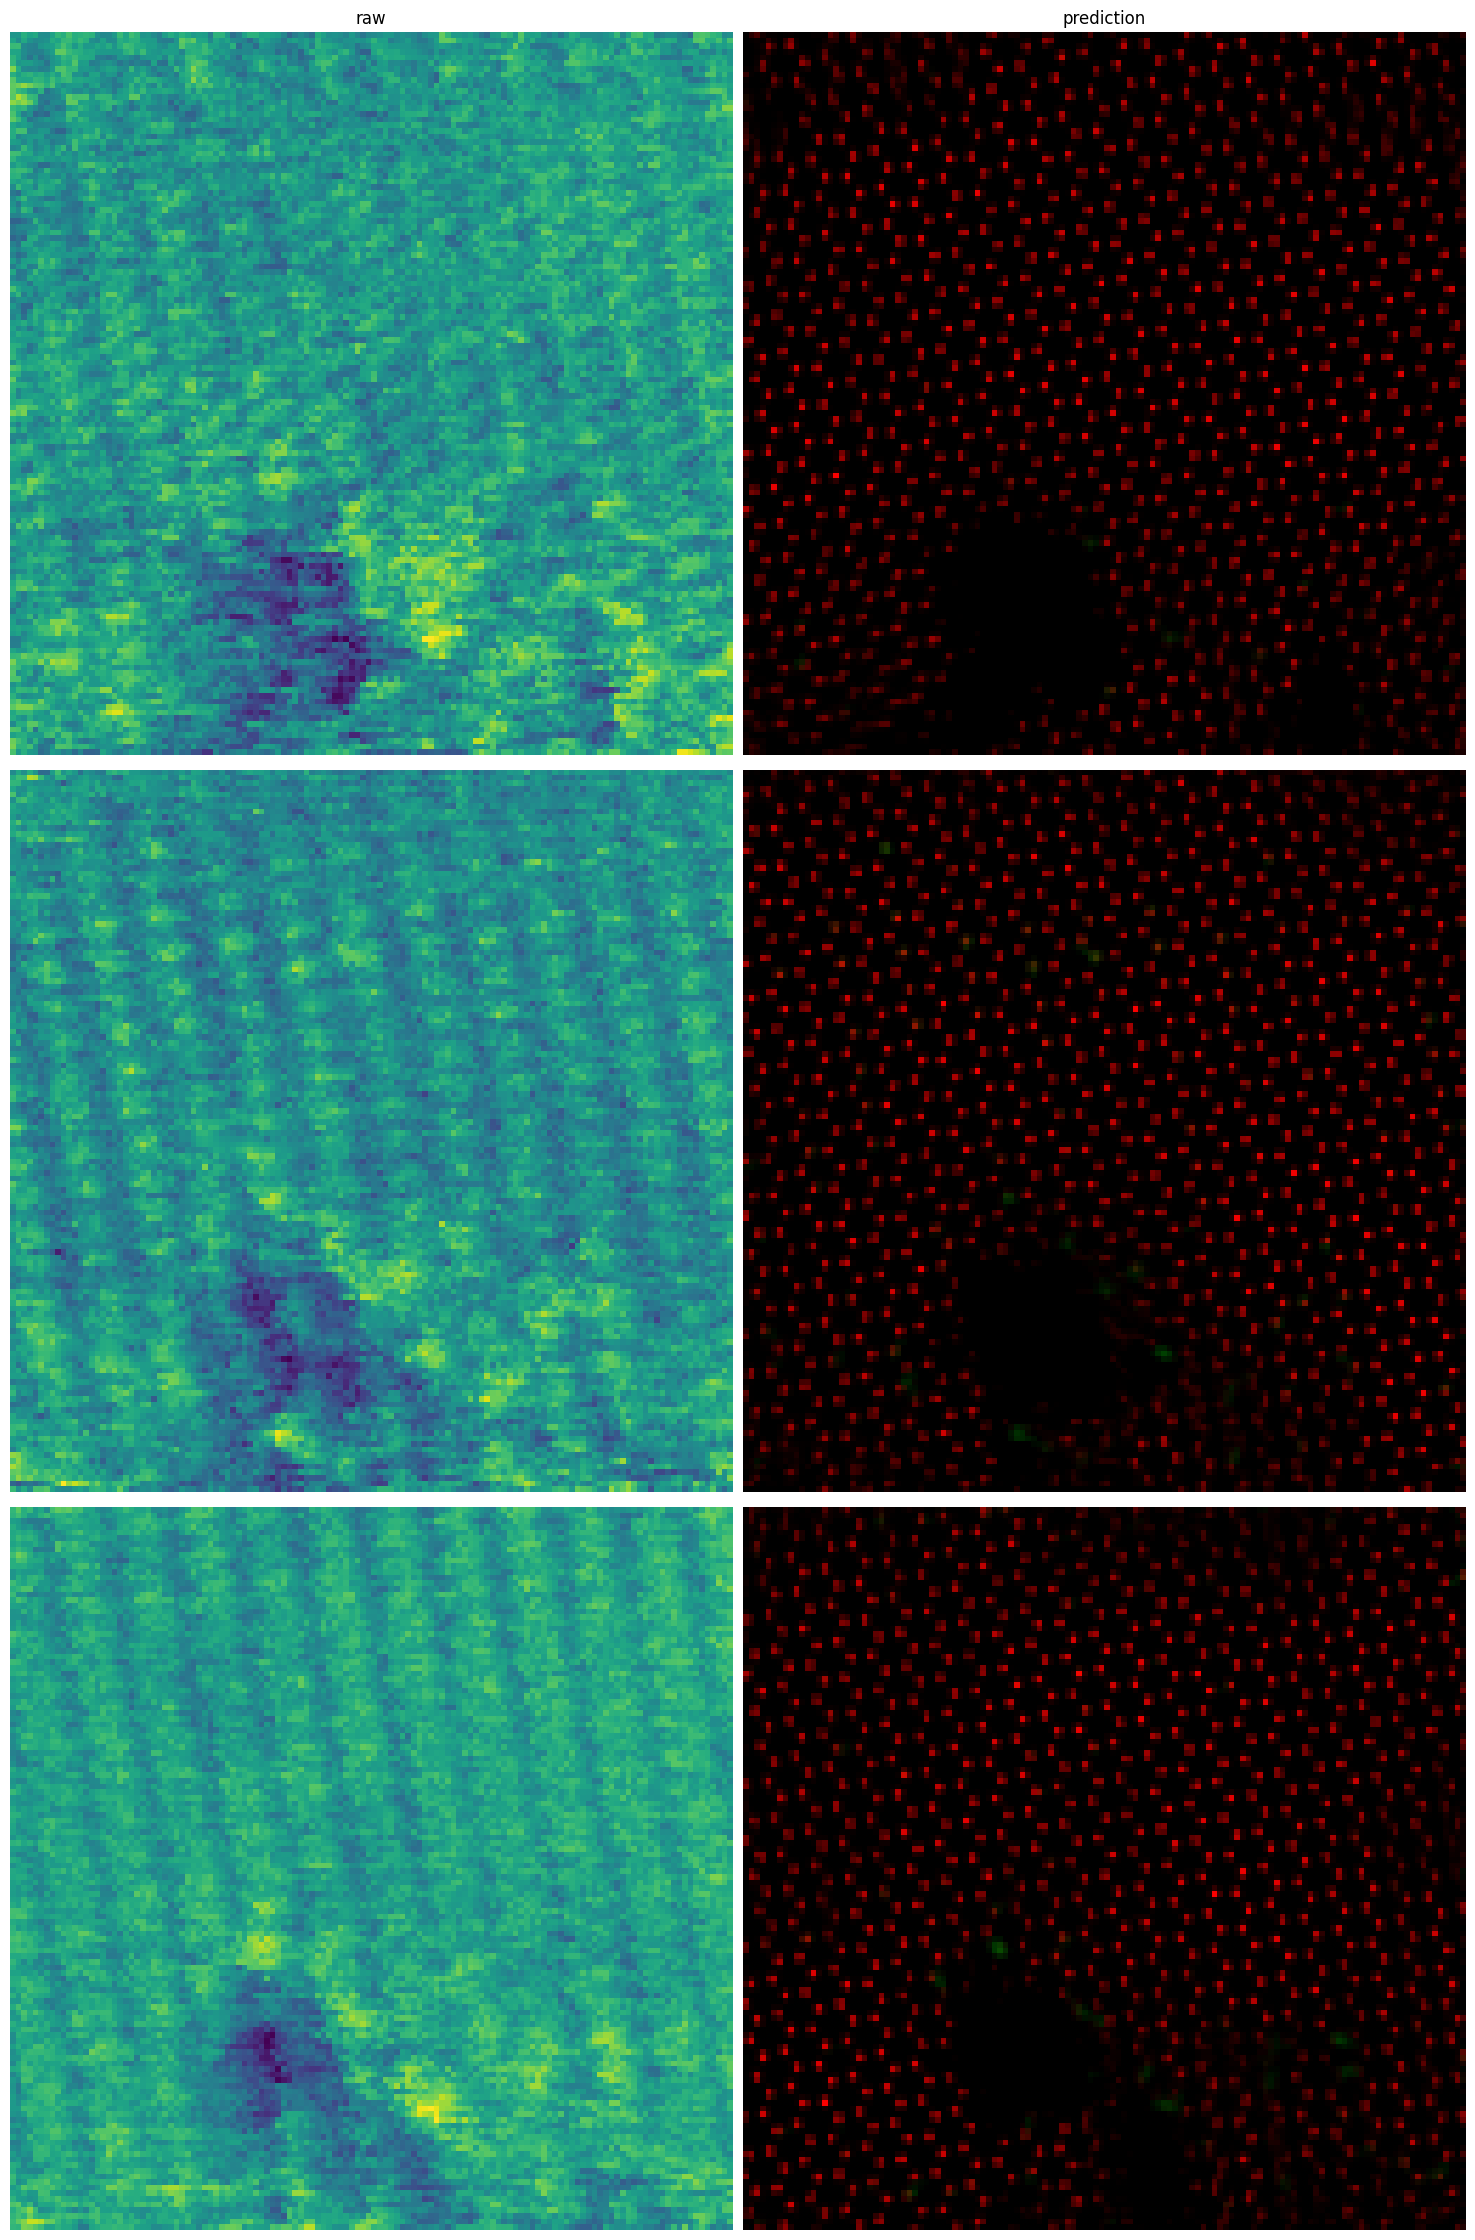

In [16]:
num_plot = 3
inds = np.array([125-9, 125, 125+9])

fig, axs = plt.subplots(num_plot,2,figsize=(15,15/2*num_plot))
fig.set_tight_layout(True)

for idx in range(num_plot):
    i = inds[idx]
    axs[idx,0].imshow(image_stack[i])
    axs[idx,1].imshow(addDimension(predictions_raw[i].clip(0,1)))
    axs[idx,0].axis('off')
    axs[idx,1].axis('off')
    
axs[0,0].set_title('raw')
axs[0,1].set_title('prediction')

plt.show(
    
)

## Combine 128\*128 images into 256\*256

In [17]:
predictions_raw.shape

(198, 128, 128, 2)

In [18]:
figsize_input = 256
figsize_output = 128
step_px = 64

step = (figsize_input-figsize_output) // step_px +1

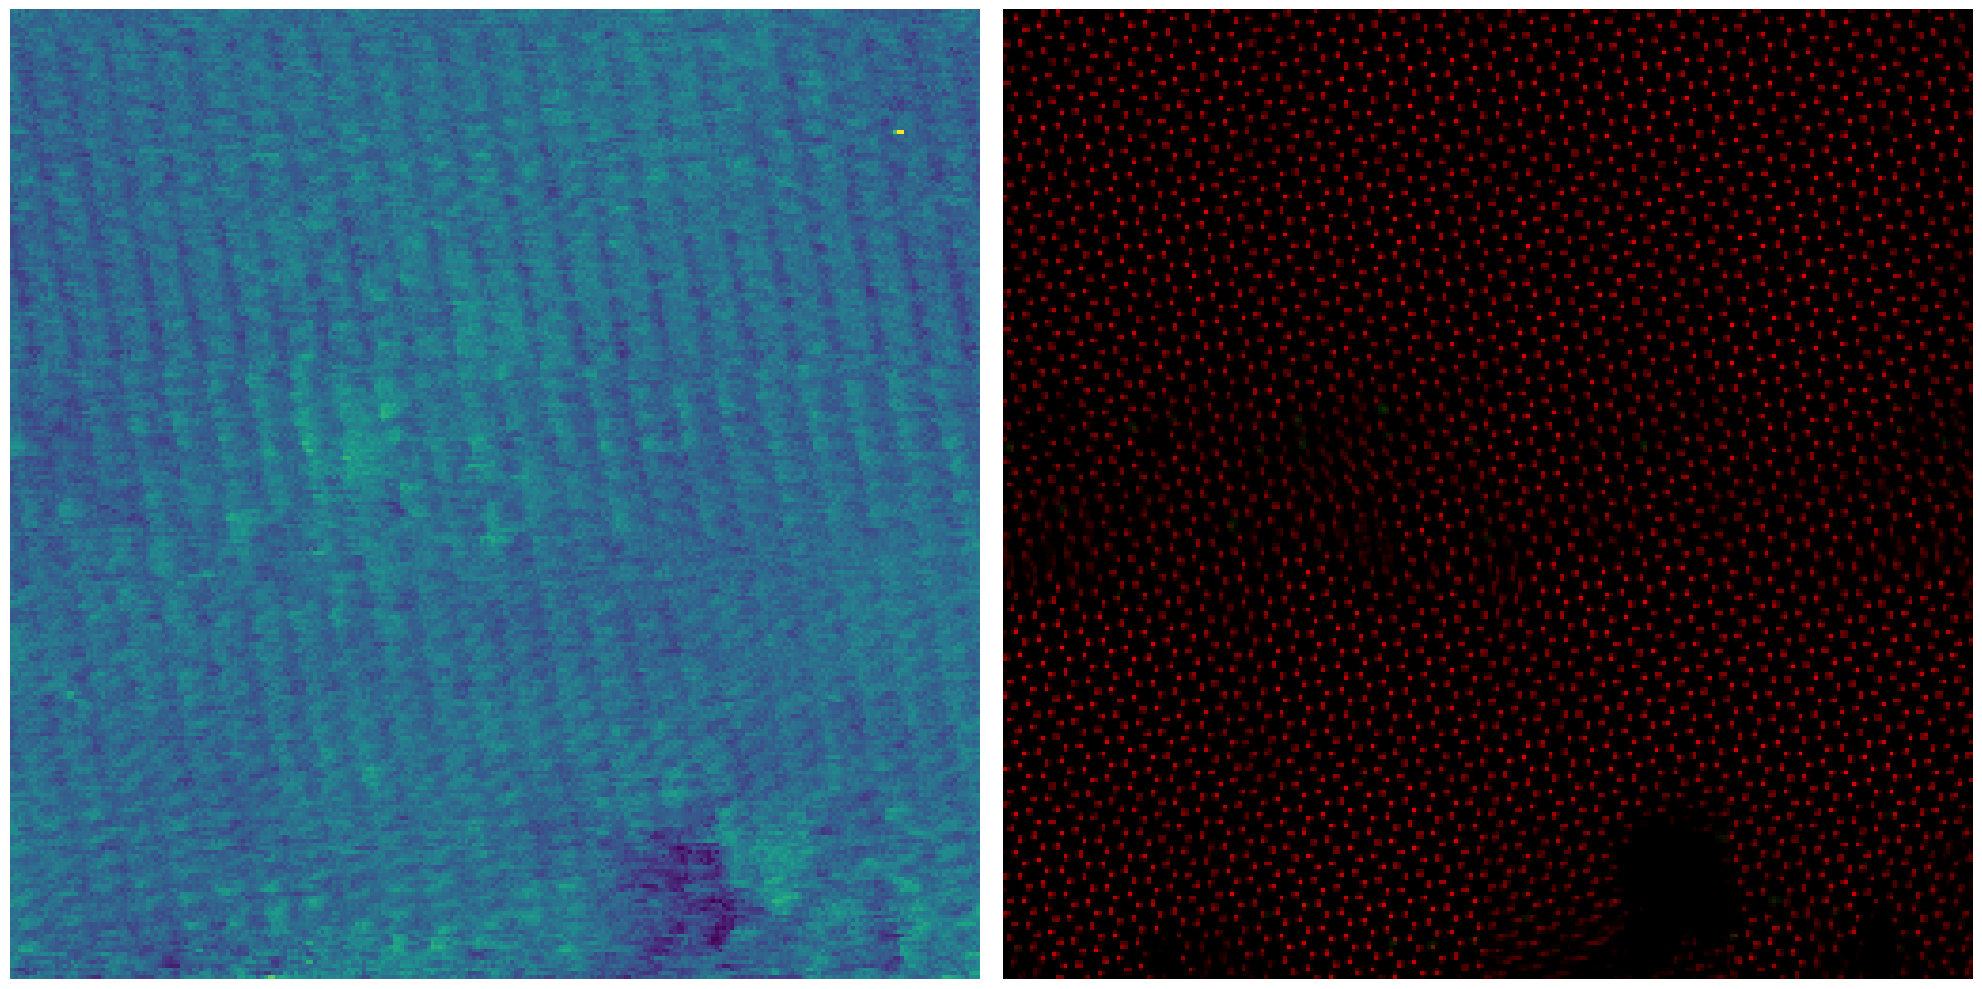

In [19]:
xy = np.linspace(0,(figsize_input-figsize_output),step)
num_img = predictions_raw.shape[0] // step // step

raw_data = np.zeros([num_img, figsize_input, figsize_input])
img_full = np.zeros([num_img, figsize_input, figsize_input, predictions_raw.shape[3]])
img_count = np.zeros_like(img_full)

for ind in range(predictions_raw.shape[0]):
    ind_img = ind // (step*step)
    ind_row = ind % (step*step) // step
    ind_col = ind % (step*step) % step
    
#     if ind_row==1 or ind_col==1:
#         continue
    
    img_full[ind_img,\
             (ind_row*step_px):(ind_row*step_px+figsize_output),\
             (ind_col*step_px):(ind_col*step_px+figsize_output)] += predictions_raw[ind]
    img_count[ind_img,\
             (ind_row*step_px):(ind_row*step_px+figsize_output),\
             (ind_col*step_px):(ind_col*step_px+figsize_output)] += 1
    
    raw_data[ind_img,\
             (ind_row*step_px):(ind_row*step_px+figsize_output),\
             (ind_col*step_px):(ind_col*step_px+figsize_output)] += image_stack[ind]
    
img_full /= img_count
raw_data /= img_count[:,:,:,0]

i = 12
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].imshow(raw_data[i])
ax[0].axis('off')
ax[1].imshow(addDimension(img_full[i].clip(0,1)))
ax[1].axis('off')
fig.tight_layout()
plt.show()